# Loads in the dataframes

In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
%matplotlib inline

# loads the dataframes
higgs_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/ttH.hd5')
semi_leptonic_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/ttsemileptonic.hd5')

# labels signal vs background
semi_leptonic_df["signal"] = 0
higgs_df["signal"] = 1

# combines the dataframes and randomly shuffles the rows
full_df = semi_leptonic_df.append(higgs_df, ignore_index=True)
full_df = shuffle(full_df)

In [ ]:
event_cols = [
    "BiasedDPhi",
    "DiJet_mass",
    "HT",
    "InputMet_InputJet_mindPhi",
    "InputMet_pt",
    "MHT_pt",
    "MinChi",
    "MinOmegaHat",
    "MinOmegaTilde",
    "ncleanedBJet",
    "ncleanedJet",
]

object_cols = [
    "cleanedJet_pt",
    "cleanedJet_area",
    "cleanedJet_btagDeepB",
    "cleanedJet_chHEF",
    "cleanedJet_eta",
    "cleanedJet_mass",
    "cleanedJet_neHEF",
    "cleanedJet_phi",
]

df = full_df[event_cols + object_cols + ["signal"]]

# Splits data into event / object dataframes and train / test dataframes

In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import sequence

scaler = StandardScaler()

# columns that should not be transformed
untransformed_cols = ["ncleanedBJet", "ncleanedJet", "BiasedDPhi", "signal"]
transformed_cols = list(set(event_cols) - set(untransformed_cols))

# takes the log of each column to remove skewness
for col_name in event_cols:
    if col_name in transformed_cols:
        df[col_name] = np.log(df[col_name])

# splits data into training and validation
X, y = df.drop("signal", axis=1), df["signal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

# divides training data into object level and event level features
event_X_train, event_X_test = X_train[event_cols], X_test[event_cols]
object_X_train, object_X_test = X_train[object_cols], X_test[object_cols]

# scales features so they all have the same mean and variance
event_X_train[event_cols] = scaler.fit_transform(event_X_train[event_cols].values)
event_X_test[event_cols] = scaler.transform(event_X_test[event_cols].values)

max_jets = df["ncleanedJet"].max()

# pads input sequences with zeroes so they're all the same length
for col in object_cols:
    object_X_train[col] = sequence.pad_sequences(
        object_X_train[col].values, padding="post", dtype="float32"
    ).tolist()
    object_X_test[col] = sequence.pad_sequences(
        object_X_test[col].values, padding="post", dtype="float32"
    ).tolist()

print(
    "Removed Columns:",
    [col for col in full_df.columns if col not in set(event_cols + object_cols)],
)
X_train.head()

Removed Columns: ['dataset', 'entry', 'InputMet_phi', 'MHT_phi', 'hashed_filename', 'weight_nominal', 'xs_weight', 'signal']


,BiasedDPhi,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_pt,MHT_pt,MinChi,MinOmegaHat,MinOmegaTilde,ncleanedBJet,ncleanedJet,cleanedJet_pt,cleanedJet_area,cleanedJet_btagDeepB,cleanedJet_chHEF,cleanedJet_eta,cleanedJet_mass,cleanedJet_neHEF,cleanedJet_phi
368587,-2.477164,5.043188,5.993621,0.038319,5.673323,5.558128,0.259275,0.162669,-0.006131,2,6,"[107.861694, 95.976135, 60.5911, 52.686752, 50...","[0.47875977, 0.4987793, 0.4987793, 0.47875977,...","[0.70214844, 0.9975586, 0.054138184, 0.0120620...","[0.4140625, 0.4453125, 0.7734375, 0.71875, 0.3...","[0.7246094, -0.5961914, 1.3046875, 1.5537109, ...","[17.34375, 10.015625, 7.9492188, 8.4296875, 11...","[0.0546875, 0.04736328, 0.061035156, 0.0229492...","[-1.0253906, -0.4645996, -2.7851562, 0.4685058..."
268887,-2.954600,4.880354,5.334540,0.982049,5.300190,5.317198,0.451583,0.126202,-0.154518,0,3,"[95.02741, 65.30184, 47.04803]","[0.55859375, 0.4987793, 0.47875977]","[0.025314331, 0.011131287, 0.06390381]","[0.6640625, 0.828125, 0.484375]","[0.80566406, -0.68310547, -2.3183594]","[22.375, 7.5546875, 9.046875]","[0.13085938, 0.033691406, 0.18359375]","[-1.5576172, -1.1855469, -1.6289062]"
151119,-2.471671,4.803737,5.738283,1.025005,5.606721,5.681576,0.451583,0.047105,-0.360697,0,2,"[168.99663, 141.53412]","[0.45874023, 0.4987793]","[0.41552734, 0.018371582]","[0.40234375, 0.421875]","[-0.52441406, -0.95654297]","[13.390625, 14.5859375]","[0.2265625, 0.46484375]","[2.6269531, 1.9570312]"
69494,-3.098624,4.243726,5.332778,1.131906,5.393628,5.332594,0.451583,-0.058756,-1.017858,1,2,"[150.23041, 56.781918]","[0.50878906, 0.50878906]","[0.9604492, 0.23413086]","[0.7265625, 0.40234375]","[1.8300781, 1.09375]","[10.90625, 6.3867188]","[0.0, 0.11328125]","[-2.2910156, -2.3339844]"
176644,-2.326163,4.713464,5.648413,0.904503,5.482720,5.586534,0.451583,-0.111750,-1.157825,0,2,"[214.23073, 69.609985]","[0.46875, 0.45874023]","[0.040008545, 0.010772705]","[0.59375, 0.75]","[-1.2314453, -0.7836914]","[25.03125, 7.5039062]","[0.02758789, 0.056640625]","[-2.0605469, -1.2451172]"


# Expands the lists in the df so they can be used as input

In [ ]:
temp_X_train = np.ndarray(
    shape=(object_X_train.shape[0], max_jets, len(object_X_train.columns))
)
temp_X_test = np.ndarray(
    shape=(object_X_test.shape[0], max_jets, len(object_X_test.columns))
)

# iterate through each column in the df and iterate through each value in the column and then iterate through each item in the list and then put that item in the nparray
for i, col in enumerate(object_cols):
    train_col = object_X_train[col]
    test_col = object_X_test[col]

    for j, event in enumerate(train_col):
        for k, item in enumerate(event):
            temp_X_train[j][k][i] = item

    for j, event in enumerate(test_col):
        for k, item in enumerate(event):
            temp_X_test[j][k][i] = item

object_X_train = temp_X_train
object_X_test = temp_X_test

# Scales the data

In [ ]:
from sklearn.preprocessing import RobustScaler

nz = np.any(object_X_train, -1)
object_X_train[nz] = RobustScaler().fit_transform(object_X_train[nz])
nz = np.any(object_X_test, -1)
object_X_test[nz] = RobustScaler().fit_transform(object_X_test[nz])

# Saves numpy arrays so I don't have to preprocess each time

In [ ]:
np.save('/content/drive/MyDrive/RNN_classifier/object_X_train.npy', object_X_train)
np.save('/content/drive/MyDrive/RNN_classifier/object_X_test.npy', object_X_test)

# Loads numpy arrays

In [129]:
object_X_train = np.load('/content/drive/MyDrive/RNN_classifier/object_X_train.npy')
object_X_test = np.load('/content/drive/MyDrive/RNN_classifier/object_X_test.npy')

# Plots the jet positions as a scatter plot to visualize the transformations

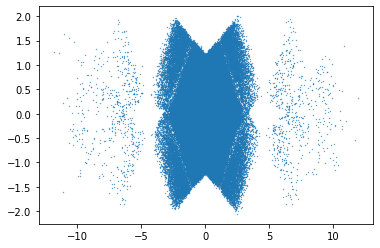

In [130]:
import matplotlib.pyplot as plt
from numpy.random import randint

i = randint(0, object_X_train.shape[0])
# eta, phi
plt.scatter(object_X_train[:, :, 7], object_X_train[:, :, 4], s=0.1)

# Hyperparameters

In [131]:
# binary classifier neural network
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from sklearn.utils import class_weight

# hyperparameters
lr = 0.01
activation = "relu"
batch_size = 64
epochs = 10
patience = 10
loss = "binary_crossentropy"
lstm_l2 = 0#1e-6
mlp_l2 = 0#1e-4

optimizer = keras.optimizers.Adam(
    learning_rate=lr,
)

# metrics

def f1_score(y_true, y_pred):  # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="AUC"),
    f1_score,
]

# weighting the classes lowers accuracy and precision but increases recall and f1 score
# class_weights = [1/float(full_df['xs_weight'].loc[full_df['signal'] == _class].mode()) for _class in np.unique(y_train)]
# class_weights = [i / min(class_weights) for i in class_weights]
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights = {l: c for l, c in zip(np.unique(y_train), class_weights)}
print(class_weights)

{0: 0.6676178944857293, 1: 1.9914875333986761}


# Callbacks

In [132]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    verbose=1,
    patience=patience,
    mode="auto",
    restore_best_weights=True,
)

# saves the network at regular intervals so you can pick the best version
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/RNN_classifier/best_model.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    mode='auto'
)

trainlog_filepath = "/content/drive/MyDrive/RNN_classifier/trainlog.csv"

csv_logger = keras.callbacks.CSVLogger(
  trainlog_filepath, 
  separator=',', 
  append = False,
)

# Defines and compiles the model

In [133]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Concatenate, BatchNormalization
from keras.regularizers import l2
from keras import Model

DNN_model = Sequential(
    [
        Dense(200, input_shape=(len(event_cols),), activation=activation, kernel_regularizer=l2(mlp_l2)),
        BatchNormalization(),
    ]
)

RNN_model = Sequential(
    [
        LSTM(
            100,
            input_shape=(max_jets, len(object_cols)),
            activation="tanh",
            unroll=False,
            recurrent_dropout=0.2,
            kernel_regularizer=l2(lstm_l2),
            return_sequences=True,
        ),

        LSTM(
            100,
            activation='tanh',
            unroll=False,
            kernel_regularizer=l2(lstm_l2),
            recurrent_dropout=0.2),
    ]
)

merged = Concatenate()([DNN_model.output, RNN_model.output])
z = Dense(200, activation=activation, kernel_regularizer=l2(mlp_l2))(merged)
z = BatchNormalization()(z)
z = Dense(100, activation=activation, kernel_regularizer=l2(mlp_l2))(z)
z = BatchNormalization()(z)
z = Dense(100, activation=activation, kernel_regularizer=l2(mlp_l2))(z)
z = BatchNormalization()(z)
z = Dense(100, activation=activation, kernel_regularizer=l2(mlp_l2))(z)
z = BatchNormalization()(z)
z = Dense(100, activation=activation, kernel_regularizer=l2(mlp_l2))(z)
z = BatchNormalization()(z)
z = Dense(100, activation=activation, kernel_regularizer=l2(mlp_l2))(z)
z = BatchNormalization()(z)
z = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[DNN_model.input, RNN_model.input], outputs=z)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS)

# Loads pre-trained model

In [ ]:
model = keras.models.load_model(
    '/content/drive/MyDrive/RNN_classifier/best_model.h5',
    custom_objects={'f1_score': f1_score})

# Trains the model

In [ ]:
history = model.fit(
    [event_X_train, object_X_train],
    y_train,
    batch_size=batch_size,
    class_weight=class_weights,
    epochs=100,
    callbacks=[early_stopping, checkpoint, reduce_lr, csv_logger],
    validation_data=([event_X_test, object_X_test], y_test),
    verbose=1,
)

Epoch 1/100
4635/4636 [============================>.] - ETA: 0s - loss: 0.4718 - accuracy: 0.7758 - precision: 0.5367 - recall: 0.7822 - AUC: 0.8571 - f1_score: 0.6321
Epoch 00001: val_loss improved from inf to 0.47240, saving model to /content/drive/MyDrive/RNN_classifier/best_model.h5
4636/4636 [==============================] - 363s 77ms/step - loss: 0.4718 - accuracy: 0.7758 - precision: 0.5367 - recall: 0.7822 - AUC: 0.8571 - f1_score: 0.6321 - val_loss: 0.4724 - val_accuracy: 0.7832 - val_precision: 0.5455 - val_recall: 0.8176 - val_AUC: 0.8756 - val_f1_score: 0.6486 - lr: 0.0100
Epoch 2/100
4636/4636 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.7892 - precision: 0.5559 - recall: 0.7979 - AUC: 0.8723 - f1_score: 0.6508
Epoch 00002: val_loss did not improve from 0.47240
4636/4636 [==============================] - 357s 77ms/step - loss: 0.4481 - accuracy: 0.7892 - precision: 0.5559 - recall: 0.7979 - AUC: 0.8723 - f1_score: 0.6508 - val_loss: 0.6092 - v

# Evaluates the model

In [ ]:
y_pred = model.predict([event_X_test, object_X_test])

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall', 'AUC']
  fig = plt.figure(figsize=(20, 20))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ")
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
  
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()

plot_metrics(history)

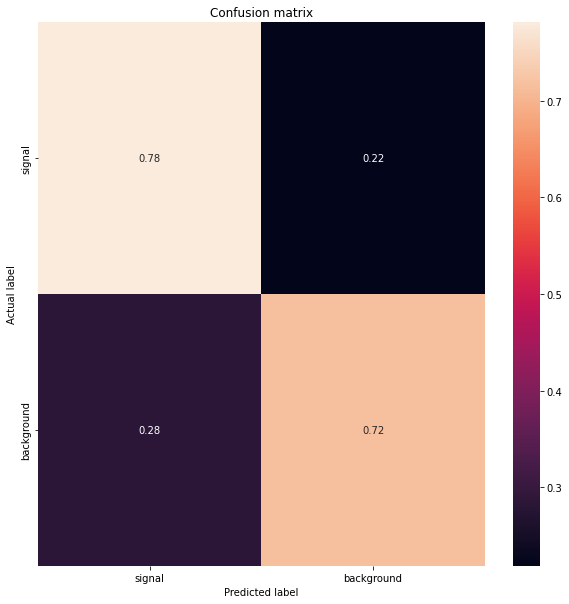

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p, normalize='true')
  plt.figure(figsize=(10, 10))
  sns.heatmap(cm, annot=True, xticklabels=['signal', 'background'], yticklabels=['signal', 'background'])

  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

plot_cm(y_test, y_pred)